# Geometric Brownian motion calculations

### Setup

#### Load external packages and my codes

In [1]:
include("Include.jl");

#### Load price dataset, and model parameters

In [2]:
dataset = loaddataset();
firm_mapping_df = loadfirmmappingfile();
realworld_parameters_df = loadmodelparametersfile(MyRealWorldEquityModelParameters);
riskneutral_parameters_df = loadmodelparametersfile(MySymmetricRiskNeutralEquityModelParameters);

In [3]:
firm_mapping_df

505×3 DataFrame
 Row │ Symbol   Name                    Sector                 
     │ String7  String                  String31               
─────┼─────────────────────────────────────────────────────────
   1 │ MMM      3M                      Industrials
   2 │ AOS      A. O. Smith             Industrials
   3 │ ABT      Abbott Laboratories     Health Care
   4 │ ABBV     AbbVie                  Health Care
   5 │ ABMD     Abiomed                 Health Care
   6 │ ACN      Accenture               Information Technology
   7 │ ATVI     Activision Blizzard     Communication Services
   8 │ ADM      ADM                     Consumer Staples
   9 │ ADBE     Adobe                   Information Technology
  10 │ AAP      Advance Auto Parts      Consumer Discretionary
  11 │ AMD      Advanced Micro Devices  Information Technology
  ⋮  │    ⋮               ⋮                       ⋮
 496 │ WLTW     Willis Towers Watson    Financials
 497 │ WYNN     Wynn Resorts            Consumer Discretionary
 498 │ XEL      Xcel Energy             Utilities
 499 │ XLNX     Xilinx                  Information Technology
 500 │ XYL      Xylem                   Industrials
 501 │ YUM      Yum! Brands             Consumer Discretionary
 502 │ ZBRA     Zebra Technologies      Information Technology
 503 │ ZBH      Zimmer Biomet           Health Care
 504 │ ZION     Zions Bancorp           Financials
 505 │ ZTS      Zoetis                  Health Care
                                               484 rows omitted

## Task 1: Estimate drift parameter $\mu$

In [4]:
firm_id = 487; # AMD
Δt = (1.0/252.0); # 1 x trading day

In [5]:
# get the firm specific data from the dataset -
firm_data = dataset[firm_id];
number_of_trading_days = nrow(firm_data);

# define the range of the time values (use all for now) -
all_range = range(1,stop=number_of_trading_days,step=1) |> collect
T_all = all_range*Δt .- Δt

# Setup the normal equations -
A = [ones(number_of_trading_days) T_all];
Y = log.(firm_data[!,:volume_weighted_average_price]);

# Solve the normal equations -
θ = inv(transpose(A)*A)*transpose(A)*Y;

# get estimated μ and b (intercept) values -
b̂ = exp(θ[1]);
μ̂ = θ[2];

# compute the residuals -
residuals = Y .- A*θ;

# fit a normal distribution to the residuals -
ϵ = fit_mle(Normal, residuals);

### Visualize

In [6]:
number_of_samples = 100;
tmp_array = Array{Float64,2}(undef, number_of_samples, number_of_trading_days);
for i ∈ 1:number_of_samples
    
    # generate error -
    Z = rand(ϵ, number_of_trading_days);

    # generate a theta estimate -
    θ̂ = inv(transpose(A)*A)*transpose(A)*Y - inv(transpose(A)*A)*transpose(A)*Z
    
    # compute estimated value of Ŷ -
    Ŷ = A*θ̂;
    
    for j ∈ 1:number_of_trading_days
        tmp_array[i,j] = Ŷ[j]
    end
end

In [7]:
mean_prediction = reshape(mean(tmp_array, dims=1), number_of_trading_days);
std_prediction = reshape(std(tmp_array, dims=1), number_of_trading_days);

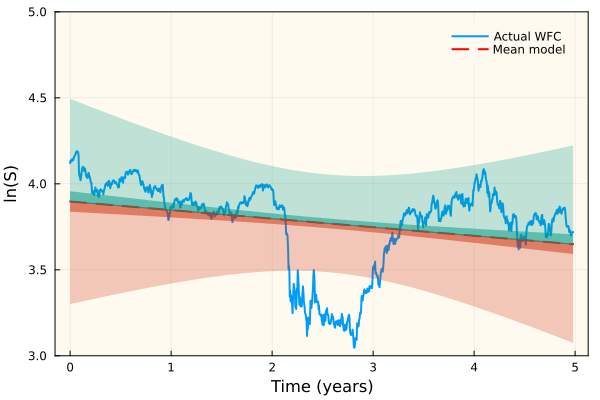

In [10]:
# compute -
ticker = firm_mapping_df[firm_id, :Symbol];
L = mean_prediction .- 3.8906*std_prediction;
U = mean_prediction .+ 3.8906*std_prediction;

LS = mean_prediction .- 3.8906*std_prediction*(sqrt(number_of_samples));
US = mean_prediction .+ 3.8906*std_prediction*(sqrt(number_of_samples));

plot(T_all, Y, label="Actual $(ticker)", lw=2, 
    bg="floralwhite", background_color_outside="white", framestyle = :box, fg_legend = :transparent, 
    ylim=(3.0,5.0))
plot!(T_all, mean_prediction, c=:red, lw=2, ls = :dash, label="Mean model")
plot!(T_all, mean_prediction, fillrange=L, c=colors[5], alpha=0.5, label="")
plot!(T_all, mean_prediction, fillrange=U, c=colors[6], alpha=0.5, label="")
plot!(T_all, mean_prediction, fillrange=LS, c=colors[5], alpha=0.25, label="")
plot!(T_all, mean_prediction, fillrange=US, c=colors[6], alpha=0.25, label="")
xlabel!("Time (years)", fontsize=18)
ylabel!("ln(S)", fontsize=18)

In [11]:
filename_mu_figure = joinpath(_PATH_TO_FIGS, "Fig-$(ticker)-MU.svg");
savefig(filename_mu_figure)

"/Users/jeffreyvarner/Desktop/course_repos/CHEME-5660-Course-Repository-F23/examples/unit-2-examples/equity-models/figs/Fig-WFC-MU.svg"